In [ ]:
!pip install lightfm
!pip install pandas
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831163 sha256=f2d56f760044e07b1605ad1c0a1d13637f7b99857caa08089f55d9bf47cf8855
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:

# Cell 1: Import required libraries
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Cell 2: Load and explore the data
# Load the datasets
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')

print("Dataset shapes:")
print(f"Books: {books.shape}")
print(f"Ratings: {ratings.shape}")

print("\nFirst few rows of books:")
print(books.head())

print("\nFirst few rows of ratings:")
print(ratings.head())

print("\nRatings distribution:")
print(ratings['rating'].value_counts().sort_index())


Dataset shapes:
Books: (10000, 23)
Ratings: (5976479, 3)

First few rows of books:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                 

Missing values in books:
book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Missing values in ratings:
user_id    0
book_id    0
rating     0
dtype: int64

Number of unique users: 53424
Number of unique books: 10000
Number of books in books.csv: 10000


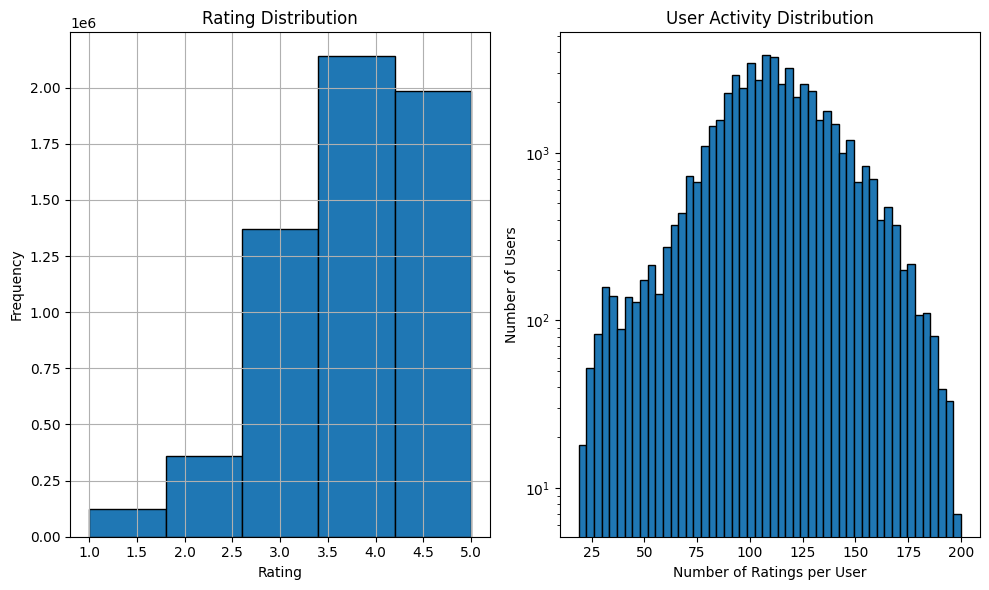

In [ ]:
# Cell 3: Data preprocessing and exploration
# Check for missing values
print("Missing values in books:")
print(books.isnull().sum())

print("\nMissing values in ratings:")
print(ratings.isnull().sum())

# Basic statistics
print(f"\nNumber of unique users: {ratings['user_id'].nunique()}")
print(f"Number of unique books: {ratings['book_id'].nunique()}")
print(f"Number of books in books.csv: {books['book_id'].nunique()}")

# Check rating distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
ratings['rating'].hist(bins=5, edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
user_activity = ratings.groupby('user_id').size()
plt.hist(user_activity, bins=50, edgecolor='black')
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# Cell 4: Filter data for better performance (optional - adjust thresholds as needed)
# Filter users with at least 5 ratings and books with at least 5 ratings
min_user_ratings = 5
min_book_ratings = 5

user_counts = ratings['user_id'].value_counts()
book_counts = ratings['book_id'].value_counts()

active_users = user_counts[user_counts >= min_user_ratings].index
popular_books = book_counts[book_counts >= min_book_ratings].index

filtered_ratings = ratings[
    (ratings['user_id'].isin(active_users)) &
    (ratings['book_id'].isin(popular_books))
].copy()

print(f"Original ratings: {len(ratings)}")
print(f"Filtered ratings: {len(filtered_ratings)}")
print(f"Unique users after filtering: {filtered_ratings['user_id'].nunique()}")
print(f"Unique books after filtering: {filtered_ratings['book_id'].nunique()}")


Original ratings: 5976479
Filtered ratings: 5976479
Unique users after filtering: 53424
Unique books after filtering: 10000


In [ ]:
# Cell 5: Prepare data for LightFM
# Create mappings for user and item IDs
user_ids = filtered_ratings['user_id'].unique()
book_ids = filtered_ratings['book_id'].unique()

# Create user and item mappings
user_id_map = {id: i for i, id in enumerate(user_ids)}
book_id_map = {id: i for i, id in enumerate(book_ids)}

# Reverse mappings
reverse_user_map = {i: id for id, i in user_id_map.items()}
reverse_book_map = {i: id for id, i in book_id_map.items()}

# Map the ratings to new indices
filtered_ratings['user_idx'] = filtered_ratings['user_id'].map(user_id_map)
filtered_ratings['book_idx'] = filtered_ratings['book_id'].map(book_id_map)

print("Mapping completed!")
print(f"User indices range: 0 to {len(user_id_map)-1}")
print(f"Book indices range: 0 to {len(book_id_map)-1}")


Mapping completed!
User indices range: 0 to 53423
Book indices range: 0 to 9999


In [ ]:
# Cell 6: Create LightFM dataset and interaction matrix
# Initialize the Dataset
dataset = Dataset()
dataset.fit(users=range(len(user_ids)), items=range(len(book_ids)))

# Create interactions matrix
interactions_list = list(zip(filtered_ratings['user_idx'], filtered_ratings['book_idx'], filtered_ratings['rating']))
interactions, weights = dataset.build_interactions(interactions_list)

print(f"Interactions matrix shape: {interactions.shape}")
print(f"Sparsity: {(1 - interactions.nnz / (interactions.shape[0] * interactions.shape[1])) * 100:.2f}%")

Interactions matrix shape: (53424, 10000)
Sparsity: 98.88%


In [ ]:
# Cell 7: Split data into train and test sets
# Split the ratings data
train_ratings, test_ratings = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

# Create train and test interaction matrices
train_interactions_list = list(zip(train_ratings['user_idx'], train_ratings['book_idx'], train_ratings['rating']))
test_interactions_list = list(zip(test_ratings['user_idx'], test_ratings['book_idx'], test_ratings['rating']))

train_interactions, train_weights = dataset.build_interactions(train_interactions_list)
test_interactions, test_weights = dataset.build_interactions(test_interactions_list)

print(f"Train interactions: {train_interactions.shape}")
print(f"Test interactions: {test_interactions.shape}")


Train interactions: (53424, 10000)
Test interactions: (53424, 10000)


In [ ]:
# Cell 8: Train LightFM model
# Try different loss functions and hyperparameters
models = {}
loss_functions = ['warp', 'bpr', 'warp-kos']

for loss in loss_functions:
    print(f"Training model with {loss} loss...")
    model = LightFM(loss=loss, random_state=42, no_components=50, learning_rate=0.05)

    # warp-kos doesn't support sample weights, so train without them
    if loss == 'warp-kos':
        model.fit(train_interactions, epochs=10, verbose=True)
    else:
        model.fit(train_interactions, sample_weight=train_weights, epochs=10, verbose=True)

    models[loss] = model

print("All models trained!")


Training model with warp loss...


Epoch: 100%|██████████| 10/10 [03:04<00:00, 18.48s/it]


Training model with bpr loss...


Epoch: 100%|██████████| 10/10 [02:58<00:00, 17.84s/it]


Training model with warp-kos loss...


Epoch: 100%|██████████| 10/10 [04:46<00:00, 28.64s/it]

All models trained!


In [ ]:
# Cell 9: Evaluate models with comprehensive metrics
from lightfm.evaluation import recall_at_k
import math

def calculate_ndcg_at_k(model, interactions, k=10):
    """Calculate NDCG@k for the model"""
    n_users, n_items = interactions.shape
    ndcg_scores = []

    for user_id in range(min(1000, n_users)):  # Sample users for efficiency
        # Get user's actual interactions
        user_items = interactions.getrow(user_id).indices
        if len(user_items) == 0:
            continue

        # Get predictions for all items
        scores = model.predict(user_id, np.arange(n_items))

        # Get top k predictions
        top_k_items = np.argsort(scores)[::-1][:k]

        # Calculate DCG
        dcg = 0
        for i, item in enumerate(top_k_items):
            if item in user_items:
                dcg += 1 / math.log2(i + 2)  # i+2 because log2(1) = 0

        # Calculate IDCG (assuming all relevant items are in top positions)
        relevant_items = min(len(user_items), k)
        idcg = sum(1 / math.log2(i + 2) for i in range(relevant_items))

        # Calculate NDCG
        if idcg > 0:
            ndcg_scores.append(dcg / idcg)

    return np.mean(ndcg_scores) if ndcg_scores else 0

def evaluate_model(model, train_interactions, test_interactions, k=10):
    """Evaluate model performance with comprehensive metrics"""
    # Precision@k
    train_precision = precision_at_k(model, train_interactions, k=k).mean()
    test_precision = precision_at_k(model, test_interactions, k=k).mean()

    # Recall@k
    train_recall = recall_at_k(model, train_interactions, k=k).mean()
    test_recall = recall_at_k(model, test_interactions, k=k).mean()

    # AUC
    train_auc = auc_score(model, train_interactions).mean()
    test_auc = auc_score(model, test_interactions).mean()

    # NDCG@k (calculated on a sample for efficiency)
    print(f"    Calculating NDCG@{k}...")
    train_ndcg = calculate_ndcg_at_k(model, train_interactions, k=k)
    test_ndcg = calculate_ndcg_at_k(model, test_interactions, k=k)

    return {
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_ndcg': train_ndcg,
        'test_ndcg': test_ndcg
    }

# Evaluate all models
results = {}
for loss, model in models.items():
    print(f"\nEvaluating {loss.upper()} model...")
    results[loss] = evaluate_model(model, train_interactions, test_interactions)
    print(f"\n{loss.upper()} Model Results:")
    print(f"Train Precision@10: {results[loss]['train_precision']:.4f}")
    print(f"Test Precision@10:  {results[loss]['test_precision']:.4f}")
    print(f"Train Recall@10:    {results[loss]['train_recall']:.4f}")
    print(f"Test Recall@10:     {results[loss]['test_recall']:.4f}")
    print(f"Train NDCG@10:      {results[loss]['train_ndcg']:.4f}")
    print(f"Test NDCG@10:       {results[loss]['test_ndcg']:.4f}")
    print(f"Train AUC:          {results[loss]['train_auc']:.4f}")
    print(f"Test AUC:           {results[loss]['test_auc']:.4f}")

# Select best model (based on test NDCG as it's a comprehensive ranking metric)
best_loss = max(results.keys(), key=lambda x: results[x]['test_ndcg'])
best_model = models[best_loss]
print(f"\nBest model (based on Test NDCG@10): {best_loss.upper()}")
print(f"Best model Test NDCG@10: {results[best_loss]['test_ndcg']:.4f}")



Evaluating WARP model...
    Calculating NDCG@10...

WARP Model Results:
Train Precision@10: 0.5397
Test Precision@10:  0.1180
Train Recall@10:    0.0637
Test Recall@10:     0.0552
Train NDCG@10:      0.5655
Test NDCG@10:       0.1204
Train AUC:          0.9694
Test AUC:           0.9529

Evaluating BPR model...
    Calculating NDCG@10...

BPR Model Results:
Train Precision@10: 0.4895
Test Precision@10:  0.0890
Train Recall@10:    0.0572
Test Recall@10:     0.0418
Train NDCG@10:      0.5428
Test NDCG@10:       0.0942
Train AUC:          0.9246
Test AUC:           0.9022

Evaluating WARP-KOS model...
    Calculating NDCG@10...

WARP-KOS Model Results:
Train Precision@10: 0.5406
Test Precision@10:  0.1142
Train Recall@10:    0.0638
Test Recall@10:     0.0532
Train NDCG@10:      0.5457
Test NDCG@10:       0.1097
Train AUC:          0.9221
Test AUC:           0.9115

Best model (based on Test NDCG@10): WARP
Best model Test NDCG@10: 0.1204


In [ ]:
# Cell 10: Book-to-book recommendation function
def get_book_recommendations(book_id, n_recommendations=10):
    """
    Get top N book recommendations for a given book_id
    """
    if book_id not in book_id_map:
        return f"Book ID {book_id} not found in the dataset"

    book_idx = book_id_map[book_id]

    # Get book features/embeddings
    book_embeddings = best_model.item_embeddings
    book_embedding = book_embeddings[book_idx]

    # Calculate similarities with all other books
    similarities = np.dot(book_embeddings, book_embedding)

    # Get top N similar books (excluding the input book)
    similar_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]
    similar_book_ids = [reverse_book_map[idx] for idx in similar_indices]
    similarity_scores = similarities[similar_indices]

    # Get book details
    book_details = books[books['book_id'].isin(similar_book_ids + [book_id])]
    input_book = book_details[book_details['book_id'] == book_id].iloc[0]

    print(f"Input Book: {input_book['title']} by {input_book['authors']}")
    print(f"Average Rating: {input_book['average_rating']:.2f}")
    print("\nTop {} Recommendations:".format(n_recommendations))
    print("="*80)

    recommendations = []
    for i, (rec_book_id, similarity) in enumerate(zip(similar_book_ids, similarity_scores)):
        book_info = book_details[book_details['book_id'] == rec_book_id]
        if not book_info.empty:
            book_info = book_info.iloc[0]
            rec_data = {
                'rank': i + 1,
                'book_id': rec_book_id,
                'title': book_info['title'],
                'authors': book_info['authors'],
                'average_rating': book_info['average_rating'],
                'similarity': similarity
            }
            recommendations.append(rec_data)
            print(f"{i+1:2d}. {book_info['title'][:50]:<50} by {book_info['authors'][:30]:<30}")
            print(f"    Rating: {book_info['average_rating']:.2f} | Similarity: {similarity:.4f}")
            print()

    return recommendations


In [ ]:
# Cell 11: User-based recommendation function
def get_user_recommendations(user_id, n_recommendations=10):
    """
    Get top N book recommendations for a given user_id
    """
    if user_id not in user_id_map:
        return f"User ID {user_id} not found in the dataset"

    user_idx = user_id_map[user_id]

    # Get all book indices
    all_book_indices = np.arange(len(book_id_map))

    # Predict scores for all books for this user
    scores = best_model.predict(user_idx, all_book_indices)

    # Get books the user has already rated
    user_books = set(filtered_ratings[filtered_ratings['user_id'] == user_id]['book_id'])

    # Get top recommendations (excluding books already rated)
    book_scores = [(reverse_book_map[idx], score) for idx, score in enumerate(scores)
                   if reverse_book_map[idx] not in user_books]
    book_scores.sort(key=lambda x: x[1], reverse=True)

    top_recommendations = book_scores[:n_recommendations]

    # Get user's rating history
    user_history = filtered_ratings[filtered_ratings['user_id'] == user_id].merge(
        books[['book_id', 'title', 'authors', 'average_rating']], on='book_id'
    ).sort_values('rating', ascending=False)

    print(f"User {user_id} Rating History (Top 5):")
    print("="*80)
    for _, row in user_history.head().iterrows():
        print(f"Rating {row['rating']}: {row['title'][:50]:<50} by {row['authors'][:30]}")

    print(f"\nTop {n_recommendations} Recommendations for User {user_id}:")
    print("="*80)

    recommendations = []
    for i, (book_id, score) in enumerate(top_recommendations):
        book_info = books[books['book_id'] == book_id]
        if not book_info.empty:
            book_info = book_info.iloc[0]
            rec_data = {
                'rank': i + 1,
                'book_id': book_id,
                'title': book_info['title'],
                'authors': book_info['authors'],
                'average_rating': book_info['average_rating'],
                'predicted_score': score
            }
            recommendations.append(rec_data)
            print(f"{i+1:2d}. {book_info['title'][:50]:<50} by {book_info['authors'][:30]:<30}")
            print(f"    Avg Rating: {book_info['average_rating']:.2f} | Predicted Score: {score:.4f}")
            print()

    return recommendations


In [ ]:

# Cell 12: Interactive recommendation interface
def recommend_books():
    """Interactive function to get recommendations"""
    print("Book Recommendation System")
    print("="*50)
    print("1. Get recommendations by Book ID")
    print("2. Get recommendations by User ID")
    print("3. Get random book recommendations")

    choice = input("\nEnter your choice (1/2/3): ")

    if choice == '1':
        # Sample some book IDs for user reference
        sample_books = books.sample(5)[['book_id', 'title', 'authors']].head()
        print("\nSample Book IDs for reference:")
        for _, row in sample_books.iterrows():
            print(f"ID: {row['book_id']} - {row['title']} by {row['authors']}")

        book_id = int(input(f"\nEnter Book ID (1 to {books['book_id'].max()}): "))
        return get_book_recommendations(book_id)

    elif choice == '2':
        # Sample some user IDs for reference
        sample_users = filtered_ratings['user_id'].sample(5).values
        print(f"\nSample User IDs for reference: {sample_users}")

        user_id = int(input(f"\nEnter User ID: "))
        return get_user_recommendations(user_id)

    elif choice == '3':
        # Random book recommendations
        random_book_id = books.sample(1)['book_id'].iloc[0]
        print(f"Random book selected: {random_book_id}")
        return get_book_recommendations(random_book_id)

    else:
        print("Invalid choice!")
        return None


In [ ]:
# Cell 13: Example usage and testing
print("Testing the recommendation system with sample data...\n")

# Test book recommendations with a popular book
sample_book_id = filtered_ratings['book_id'].value_counts().index[0]  # Most rated book
print("BOOK-TO-BOOK RECOMMENDATIONS:")
book_recs = get_book_recommendations(sample_book_id)

print("\n" + "="*100 + "\n")

# Test user recommendations with an active user
sample_user_id = filtered_ratings['user_id'].value_counts().index[0]  # Most active user
print("USER-BASED RECOMMENDATIONS:")
user_recs = get_user_recommendations(sample_user_id)

print("\n" + "="*100 + "\n")


Testing the recommendation system with sample data...

BOOK-TO-BOOK RECOMMENDATIONS:
Input Book: The Hunger Games (The Hunger Games, #1) by Suzanne Collins
Average Rating: 4.34

Top 10 Recommendations:
 1. Matched (Matched, #1)                              by Ally Condie                   
    Rating: 3.68 | Similarity: 3.1968

 2. Divergent (Divergent, #1)                          by Veronica Roth                 
    Rating: 4.24 | Similarity: 3.1349

 3. I Am Number Four (Lorien Legacies, #1)             by Pittacus Lore                 
    Rating: 3.94 | Similarity: 3.1199

 4. Legend (Legend, #1)                                by Marie Lu                      
    Rating: 4.19 | Similarity: 3.0212

 5. Pandemonium (Delirium, #2)                         by Lauren Oliver                 
    Rating: 4.07 | Similarity: 2.9547

 6. Delirium (Delirium, #1)                            by Lauren Oliver                 
    Rating: 3.99 | Similarity: 2.9305

 7. Across the Universe (Acros

Model Performance Analysis (N=1 to 20):
Calculating comprehensive metrics for N=1 to 20...
Processing WARP model...
Processing BPR model...
Processing WARP-KOS model...
Results saved to 'model_evaluation_metrics_N1_to_N20.csv'


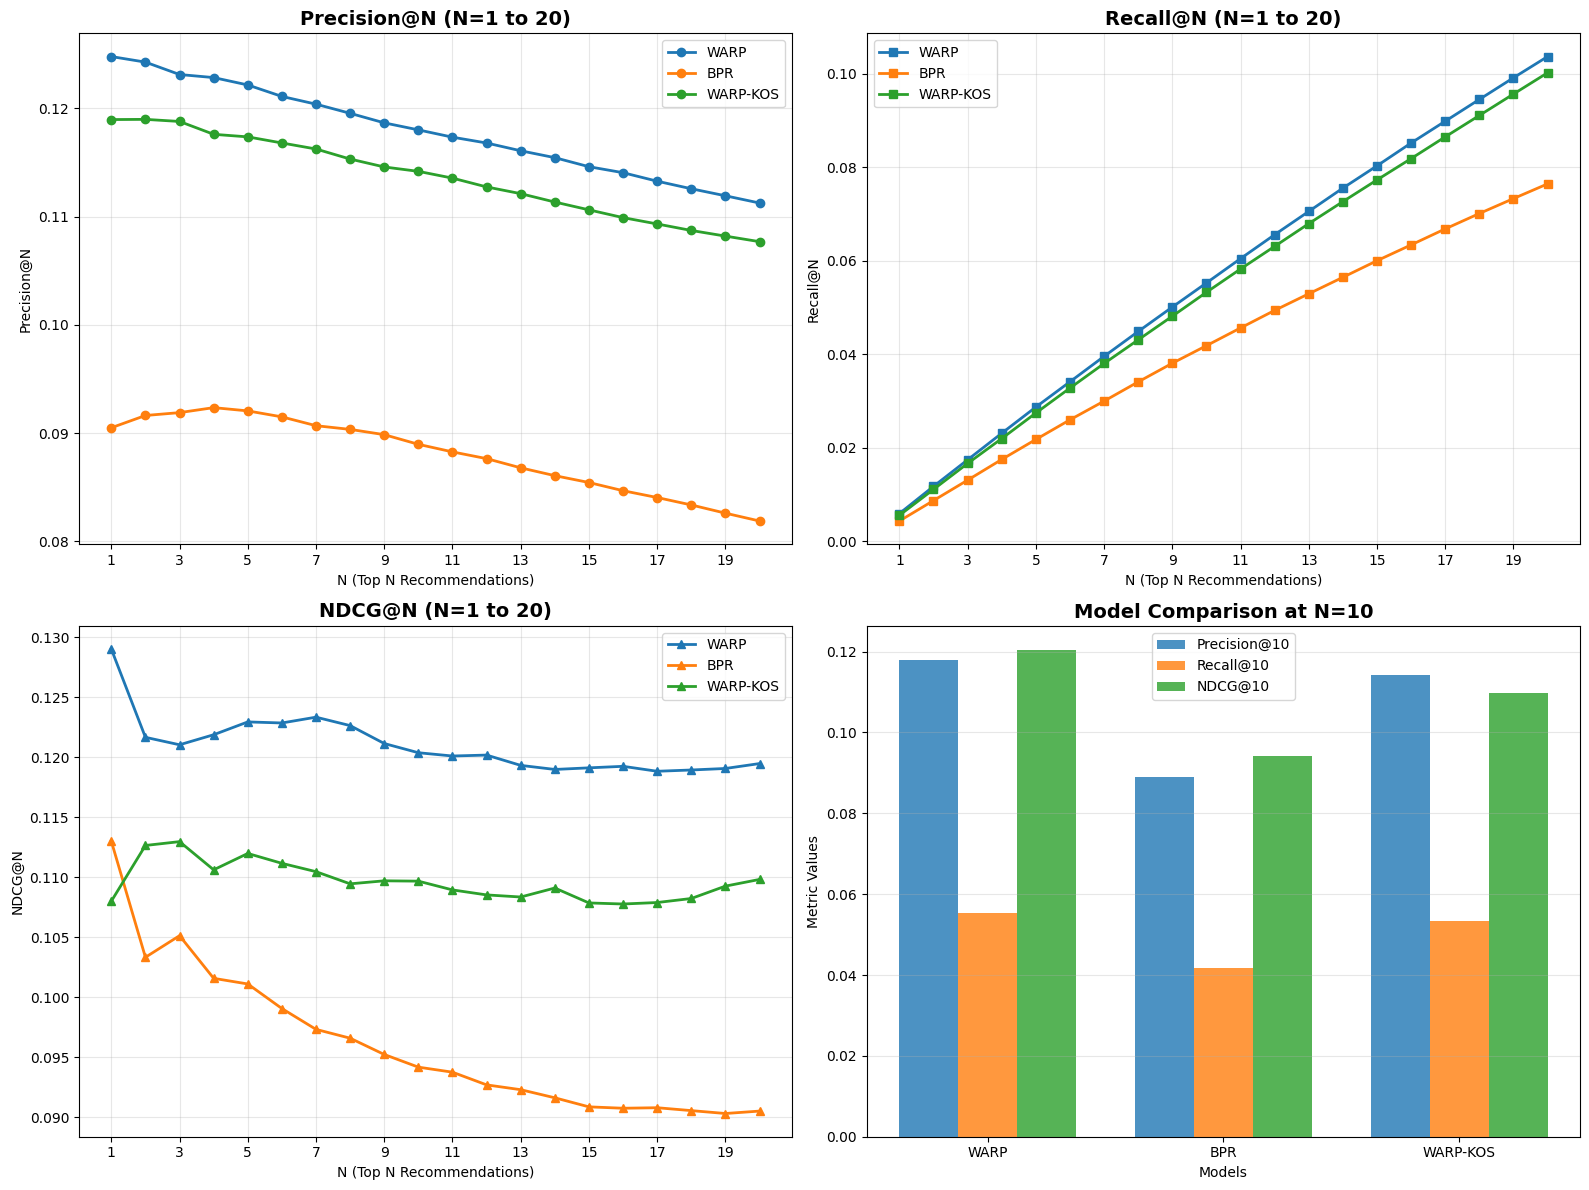


Pivot tables saved:
- precision_metrics_N1_to_N20.csv
- recall_metrics_N1_to_N20.csv
- ndcg_metrics_N1_to_N20.csv
- model_evaluation_metrics_N1_to_N20.png (plot)

SUMMARY STATISTICS FOR N=1 TO 20

Best Precision scores by model:
--------------------------------------------------
WARP    : Precision@1 = 0.1248
BPR     : Precision@4 = 0.0923
WARP-KOS: Precision@2 = 0.1190

Best Recall scores by model:
--------------------------------------------------
WARP    : Recall@20 = 0.1036
BPR     : Recall@20 = 0.0764
WARP-KOS: Recall@20 = 0.1002

Best NDCG scores by model:
--------------------------------------------------
WARP    : NDCG@1 = 0.1290
BPR     : NDCG@1 = 0.1130
WARP-KOS: NDCG@3 = 0.1130

Metrics at common N values:
--------------------------------------------------------------------------------

N = 1:
Model    Precision  Recall     NDCG      
----------------------------------------
WARP     0.1248     0.0059     0.1290    
BPR      0.0905     0.0043     0.1130    
WARP-KOS 0.1190 

In [ ]:
# Cell 14: Model analysis and insights with comprehensive metrics (N=1 to 20)
def analyze_model_performance_comprehensive():
    """Analyze and visualize model performance with metrics for N=1 to 20"""

    # Calculate metrics for N=1 to 20
    k_values = range(1, 21)
    comprehensive_results = {}

    print("Calculating comprehensive metrics for N=1 to 20...")

    for loss, model in models.items():
        print(f"Processing {loss.upper()} model...")
        model_results = []

        for k in k_values:
            # Calculate all metrics for current k
            test_precision = precision_at_k(model, test_interactions, k=k).mean()
            test_recall = recall_at_k(model, test_interactions, k=k).mean()
            test_ndcg = calculate_ndcg_at_k(model, test_interactions, k=k)

            model_results.append({
                'N': k,
                'Model': loss.upper(),
                'Precision': test_precision,
                'Recall': test_recall,
                'NDCG': test_ndcg
            })

        comprehensive_results[loss] = model_results

    # Convert to DataFrame for easier handling
    all_results = []
    for loss, results in comprehensive_results.items():
        all_results.extend(results)

    comprehensive_df = pd.DataFrame(all_results)

    # Save to CSV
    comprehensive_df.to_csv('model_evaluation_metrics_N1_to_N20.csv', index=False)
    print("Results saved to 'model_evaluation_metrics_N1_to_N20.csv'")

    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Precision@N for all models
    for loss in loss_functions:
        model_data = comprehensive_df[comprehensive_df['Model'] == loss.upper()]
        axes[0,0].plot(model_data['N'], model_data['Precision'],
                      marker='o', linewidth=2, label=loss.upper())

    axes[0,0].set_title('Precision@N (N=1 to 20)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('N (Top N Recommendations)')
    axes[0,0].set_ylabel('Precision@N')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(range(1, 21, 2))

    # Plot 2: Recall@N for all models
    for loss in loss_functions:
        model_data = comprehensive_df[comprehensive_df['Model'] == loss.upper()]
        axes[0,1].plot(model_data['N'], model_data['Recall'],
                      marker='s', linewidth=2, label=loss.upper())

    axes[0,1].set_title('Recall@N (N=1 to 20)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('N (Top N Recommendations)')
    axes[0,1].set_ylabel('Recall@N')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xticks(range(1, 21, 2))

    # Plot 3: NDCG@N for all models
    for loss in loss_functions:
        model_data = comprehensive_df[comprehensive_df['Model'] == loss.upper()]
        axes[1,0].plot(model_data['N'], model_data['NDCG'],
                      marker='^', linewidth=2, label=loss.upper())

    axes[1,0].set_title('NDCG@N (N=1 to 20)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('N (Top N Recommendations)')
    axes[1,0].set_ylabel('NDCG@N')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xticks(range(1, 21, 2))

    # Plot 4: Combined metrics at N=10 (bar chart)
    n10_data = comprehensive_df[comprehensive_df['N'] == 10]
    x = np.arange(len(loss_functions))
    width = 0.25

    precision_vals = [n10_data[n10_data['Model'] == loss.upper()]['Precision'].iloc[0]
                     for loss in loss_functions]
    recall_vals = [n10_data[n10_data['Model'] == loss.upper()]['Recall'].iloc[0]
                  for loss in loss_functions]
    ndcg_vals = [n10_data[n10_data['Model'] == loss.upper()]['NDCG'].iloc[0]
                for loss in loss_functions]

    axes[1,1].bar(x - width, precision_vals, width, label='Precision@10', alpha=0.8)
    axes[1,1].bar(x, recall_vals, width, label='Recall@10', alpha=0.8)
    axes[1,1].bar(x + width, ndcg_vals, width, label='NDCG@10', alpha=0.8)

    axes[1,1].set_title('Model Comparison at N=10', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Metric Values')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels([loss.upper() for loss in loss_functions])
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('model_evaluation_metrics_N1_to_N20.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create pivot tables for better readability
    precision_pivot = comprehensive_df.pivot(index='N', columns='Model', values='Precision')
    recall_pivot = comprehensive_df.pivot(index='N', columns='Model', values='Recall')
    ndcg_pivot = comprehensive_df.pivot(index='N', columns='Model', values='NDCG')

    # Save pivot tables to separate CSV files
    precision_pivot.to_csv('precision_metrics_N1_to_N20.csv')
    recall_pivot.to_csv('recall_metrics_N1_to_N20.csv')
    ndcg_pivot.to_csv('ndcg_metrics_N1_to_N20.csv')

    print("\nPivot tables saved:")
    print("- precision_metrics_N1_to_N20.csv")
    print("- recall_metrics_N1_to_N20.csv")
    print("- ndcg_metrics_N1_to_N20.csv")
    print("- model_evaluation_metrics_N1_to_N20.png (plot)")

    # Display summary statistics
    print("\n" + "="*100)
    print("SUMMARY STATISTICS FOR N=1 TO 20")
    print("="*100)

    # Best performing N for each metric and model
    for metric in ['Precision', 'Recall', 'NDCG']:
        print(f"\nBest {metric} scores by model:")
        print("-" * 50)
        for loss in loss_functions:
            model_data = comprehensive_df[comprehensive_df['Model'] == loss.upper()]
            best_row = model_data.loc[model_data[metric].idxmax()]
            print(f"{loss.upper():<8}: {metric}@{int(best_row['N'])} = {best_row[metric]:.4f}")

    # Show specific values at common N points
    common_n_values = [1, 5, 10, 15, 20]
    print(f"\nMetrics at common N values:")
    print("-" * 80)

    for n in common_n_values:
        print(f"\nN = {n}:")
        n_data = comprehensive_df[comprehensive_df['N'] == n]
        print(f"{'Model':<8} {'Precision':<10} {'Recall':<10} {'NDCG':<10}")
        print("-" * 40)
        for loss in loss_functions:
            row = n_data[n_data['Model'] == loss.upper()].iloc[0]
            print(f"{loss.upper():<8} {row['Precision']:<10.4f} {row['Recall']:<10.4f} {row['NDCG']:<10.4f}")

    return comprehensive_df, precision_pivot, recall_pivot, ndcg_pivot

# Run comprehensive analysis
print("Model Performance Analysis (N=1 to 20):")
comprehensive_df, precision_pivot, recall_pivot, ndcg_pivot = analyze_model_performance_comprehensive()

# Display sample of the comprehensive results
print("\nSample of comprehensive results:")
print(comprehensive_df.head(10))

print("\nPrecision@N pivot table sample:")
print(precision_pivot.head(10))


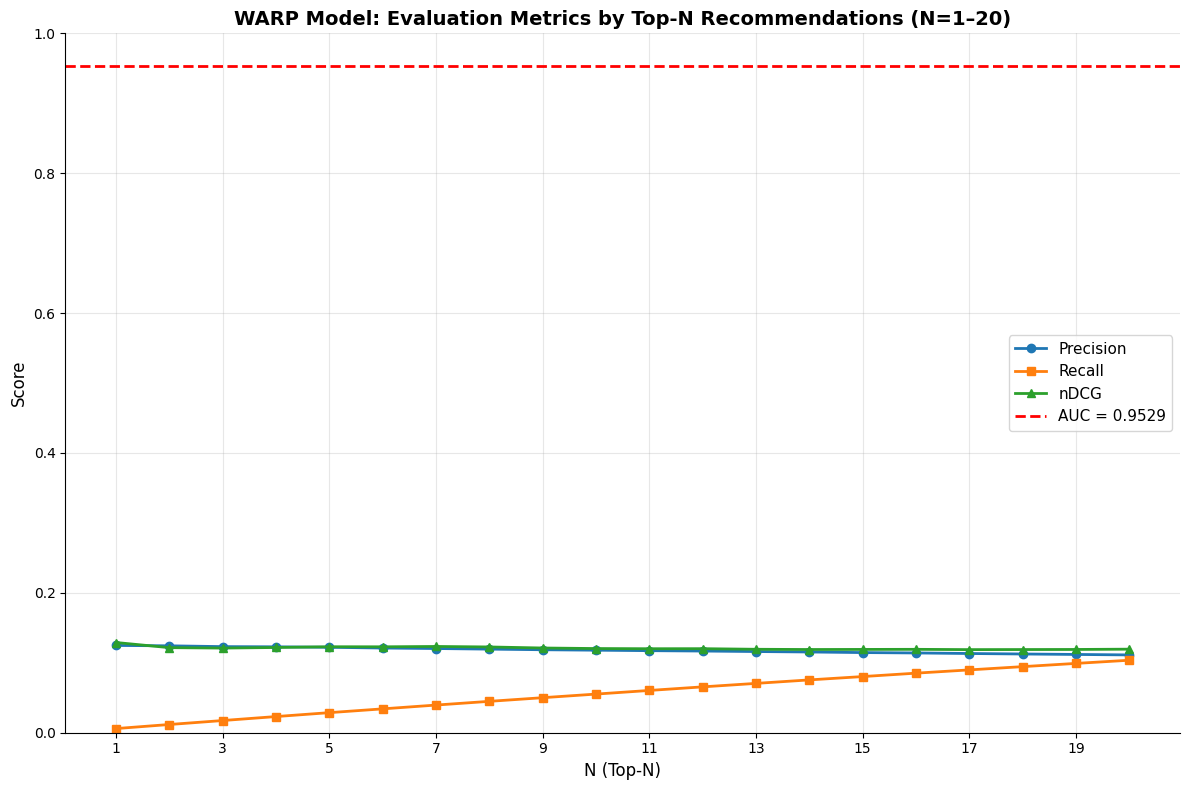

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv('model_evaluation_metrics_N1_to_N20.csv')

# Choose the model you want to visualize — options: 'WARP', 'BPR', 'WARP-KOS'
selected_model = 'WARP'  # Change to 'BPR' or 'WARP-KOS' as needed

# Define corresponding AUC values
auc_values = {
    'WARP': 0.9529,
    'BPR': 0.9022,
    'WARP-KOS': 0.9115
}

# Filter for the selected model
model_df = df[df['Model'] == selected_model]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(model_df['N'], model_df['Precision'], marker='o', linewidth=2, label='Precision')
plt.plot(model_df['N'], model_df['Recall'], marker='s', linewidth=2, label='Recall')
plt.plot(model_df['N'], model_df['NDCG'], marker='^', linewidth=2, label='nDCG')

# Add AUC line
auc = auc_values[selected_model]
plt.axhline(y=auc, linestyle='--', linewidth=2, color='red', label=f'AUC = {auc:.4f}')

# Style
plt.title(f'{selected_model} Model: Evaluation Metrics by Top-N Recommendations (N=1–20)',
          fontsize=14, fontweight='bold')
plt.xlabel('N (Top-N)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(range(1, 21, 2))
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save and display
plt.tight_layout()
plt.savefig(f'{selected_model.lower()}_metrics_plot_with_auc.png', dpi=300)
plt.show()


In [ ]:
# Cell 15: Save model and mappings (optional)
import pickle

def save_model_and_mappings():
    """Save the trained model and mappings for later use"""

    model_data = {
        'model': best_model,
        'user_id_map': user_id_map,
        'book_id_map': book_id_map,
        'reverse_user_map': reverse_user_map,
        'reverse_book_map': reverse_book_map,
        'books_df': books,
        'best_loss': best_loss
    }

    with open('book_recommendation_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)

    print("Model and mappings saved to 'book_recommendation_model.pkl'")

# Uncomment to save the model
# save_model_and_mappings()

print("\n" + "="*80)
print("RECOMMENDATION SYSTEM READY!")
print("="*80)
print("You can now use:")
print("1. get_book_recommendations(book_id, n_recommendations=10)")
print("2. get_user_recommendations(user_id, n_recommendations=10)")
print("3. recommend_books() for interactive recommendations")
print("="*80)


RECOMMENDATION SYSTEM READY!
You can now use:
1. get_book_recommendations(book_id, n_recommendations=10)
2. get_user_recommendations(user_id, n_recommendations=10)
3. recommend_books() for interactive recommendations
